## Configuro notebook

In [75]:
# configuración para notebook con instalación LOCAL
FUENTES_DIR  = '../../Datos-Fuentes/Fuentes/'     # carpeta donde se encuentran archivos .py auxiliares
DATOS_DIR    = '../../Datos-Fuentes/Datos/'      # carpeta donde se encuentran los datasets
MODELOS_DIR  = '../Modelos/'    # carpeta donde se encuentran los modelos
ARCHIVOs_DIR = '../Archivos/'   # carpeta recuperar o copiar archivos

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

## Importo librerias

In [76]:
import pandas as pd 
import numpy as np
import chardet
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_curve, classification_report
from keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

## Extraigo datos y visualizo

In [77]:
nombre_archivo = DATOS_DIR + 'creditcard.csv'

# carga archivo de datos. No tiene fila con titulos!
df= pd.read_csv(nombre_archivo)

display(df.head())

resultados = df.iloc[:,-1].value_counts(sort=True)
display(resultados)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Class
0    284315
1       492
Name: count, dtype: int64

## Class 1 ==> Fraudulenta

## Visualizo distribucion de los datos

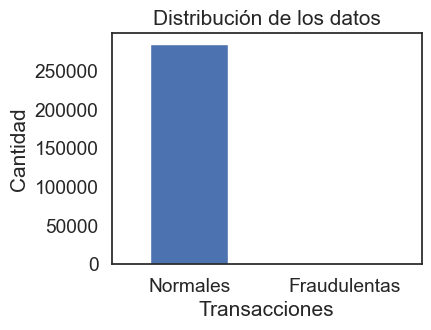

In [78]:
# Cantidad de registros normales vs. fraudulentos
plt.figure(figsize=(4,3))
resultados.plot(kind = 'bar', rot=0)
plt.xticks(range(2), ['Normales', 'Fraudulentas'])
plt.title("Distribución de los datos")
plt.xlabel("Transacciones")
plt.ylabel("Cantidad")
plt.show()

## Visualizo transacciones respecto del tiempo

Cantidad de normales:  284315
Cantidad de fraudulentos:  492


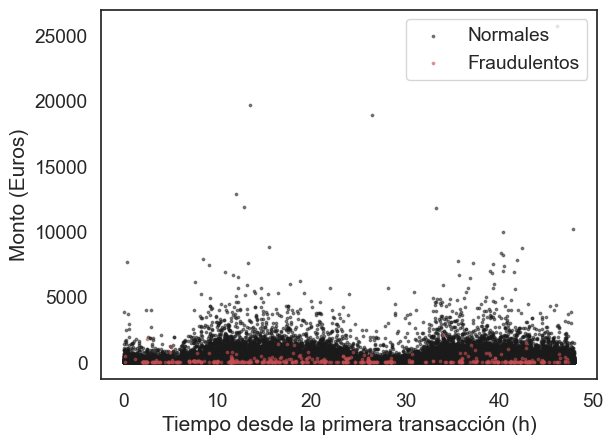

In [79]:
normales = df[df.Class==0]
fraudulentos = df[df.Class==1]

print('Cantidad de normales: ', len(normales))
print('Cantidad de fraudulentos: ', len(fraudulentos))

plt.scatter(normales.Time/3600, normales.Amount, alpha = 0.5, c='k', label='Normales', s=3)
plt.scatter(fraudulentos.Time/3600, fraudulentos.Amount, alpha = 0.5, c='r', label='Fraudulentos', s=3)
plt.xlabel('Tiempo desde la primera transacción (h)')
plt.ylabel('Monto (Euros)')
plt.legend(loc='upper right')
plt.show()

## Visualizo transacciones respecto del monto

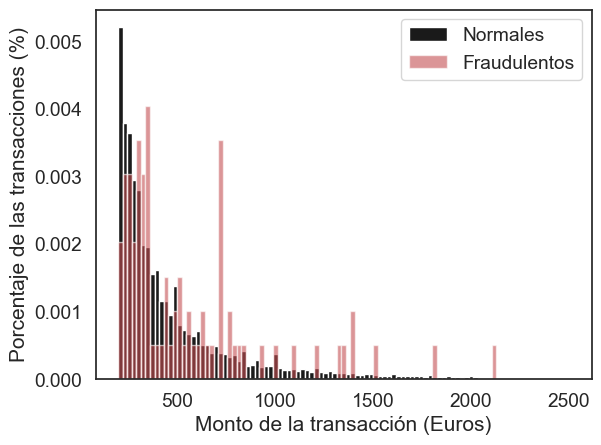

In [80]:
bins = np.linspace(200, 2500, 100)
plt.hist(normales.Amount, bins, alpha=1, density=True, label='Normales', color='k')
plt.hist(fraudulentos.Amount, bins, alpha=0.6, density=True, label='Fraudulentos', color='r')
plt.legend(loc='upper right')
plt.xlabel("Monto de la transacción (Euros)")
plt.ylabel("Porcentaje de las transacciones (%)")
plt.show()

## Como en los graficos vimos que las transacciones fraudulentas no dependen del tiempo, extraigo esos valores

In [81]:
df.drop(['Time'], axis=1, inplace=True)

## Preparo y normalizo datos

In [82]:
from sklearn.preprocessing import StandardScaler
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1,1))

from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)

X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
X_train = X_train.values

Y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_test = X_test.values

print(type(X_train.shape))
print(X_train.shape)

<class 'tuple'>
(227451, 29)


## Construyo modelo

In [83]:
dim_entrada = X_train.shape[1]          # 29
capa_entrada = Input(shape=(dim_entrada,))

encoder = Dense(25, activation='tanh')(capa_entrada)
encoder = Dense(15, activation='relu')(encoder)
encoder = Dense(10, activation='relu')(encoder)
encoder = Dense(6, activation='relu')(encoder)

decoder = Dense(10, activation='relu')(encoder)
decoder = Dense(15, activation='tanh')(decoder)
decoder = Dense(25, activation='tanh')(decoder)
decoder = Dense(29, activation='relu')(decoder)

autoencoder = Model(inputs=capa_entrada, outputs=decoder)

sgd = SGD(learning_rate=0.01)
autoencoder.compile(optimizer='sgd', loss='mse')

autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 29)]              0         
                                                                 
 dense_77 (Dense)            (None, 25)                750       
                                                                 
 dense_78 (Dense)            (None, 15)                390       
                                                                 
 dense_79 (Dense)            (None, 10)                160       
                                                                 
 dense_80 (Dense)            (None, 6)                 66        
                                                                 
 dense_81 (Dense)            (None, 10)                70        
                                                                 
 dense_82 (Dense)            (None, 15)                165 

## Entreno

In [84]:
# Configuración de EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

nits = 100
tam_lote = 128
autoencoder.fit(X_train, X_train, epochs=nits, batch_size=tam_lote, shuffle=True, validation_data=(X_test,X_test), verbose=1, callbacks=[early_stopping])

Epoch 1/100
1777/1777 [==============================] - 6s 3ms/step - loss: 1.0466 - val_loss: 1.0618
Epoch 2/100
1777/1777 [==============================] - 5s 3ms/step - loss: 1.0169 - val_loss: 1.0314
Epoch 3/100
1777/1777 [==============================] - 5s 3ms/step - loss: 0.9942 - val_loss: 1.0126
Epoch 4/100
1777/1777 [==============================] - 5s 3ms/step - loss: 0.9768 - val_loss: 0.9984
Epoch 5/100
1777/1777 [==============================] - 5s 3ms/step - loss: 0.9647 - val_loss: 0.9869
Epoch 6/100
1777/1777 [==============================] - 5s 3ms/step - loss: 0.9509 - val_loss: 0.9715
Epoch 7/100
1777/1777 [==============================] - 5s 3ms/step - loss: 0.9350 - val_loss: 0.9562
Epoch 8/100
1777/1777 [==============================] - 5s 3ms/step - loss: 0.9204 - val_loss: 0.9420
Epoch 9/100
1777/1777 [==============================] - 5s 3ms/step - loss: 0.9063 - val_loss: 0.9273
Epoch 10/100
1777/1777 [==============================] - 5s 3ms/step - l

## Validacion

1781/1781 [==============================] - 2s 1ms/step
(56962, 29)


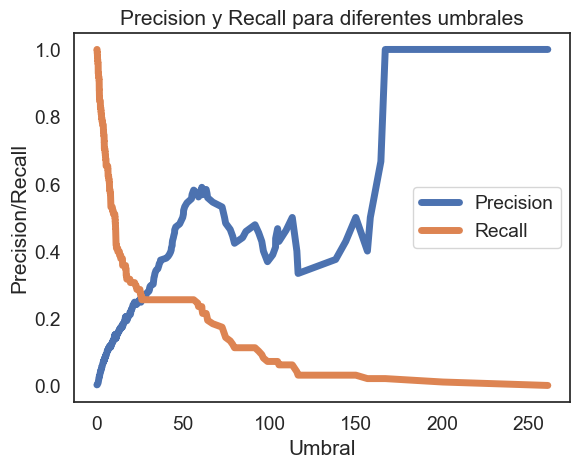

In [85]:
# Predicción X_test -> Autoencoder -> X_pred
X_pred = autoencoder.predict(X_test)
ecm = np.mean(np.power(X_test-X_pred,2), axis=1)
print(X_pred.shape)

# Gráfica precision-recall para determinar el umbral
precision, recall, umbral = precision_recall_curve(Y_test, ecm)

plt.plot(umbral, precision[1:], label="Precision",linewidth=5)
plt.plot(umbral, recall[1:], label="Recall",linewidth=5)
plt.title('Precision y Recall para diferentes umbrales')
plt.xlabel('Umbral')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

## Establezco umbral

In [102]:
# Matriz de confusión
umbral_fijo = 0.75
Y_pred = [1 if e > umbral_fijo else 0 for e in ecm]

conf_matrix = confusion_matrix(Y_test, Y_pred)
print(conf_matrix)

report = classification_report(Y_test,Y_pred)
print("Confusion matrix Training:\n%s" % report) 
umbral_fijo

[[46023 10841]
 [    4    94]]
Confusion matrix Training:
              precision    recall  f1-score   support

           0       1.00      0.81      0.89     56864
           1       0.01      0.96      0.02        98

    accuracy                           0.81     56962
   macro avg       0.50      0.88      0.46     56962
weighted avg       1.00      0.81      0.89     56962



0.75

In [103]:
autoencoder.save("fraude.keras")